In [ ]:
from IPython.display import clear_output
%pip install pandas numpy torch opencv-python torchvision tqdm scikit_learn
clear_output()

In [47]:
import pandas as pd 
import numpy as np 
import os
import io
from PIL import Image

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision

import cv2

from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [2]:
dataset_path = 'caxton_dataset'

caxton = pd.read_csv(os.path.join(dataset_path,'caxton_dataset_full.csv'))
prints = os.listdir(dataset_path)
prints = [int(pr.split('t')[1]) if pr.startswith('print') and pr != 'print107' else pr for pr in prints]
caxton = caxton[caxton['print_id'].isin(prints)]
caxton.head(3)

,img_path,timestamp,flow_rate,feed_rate,z_offset,target_hotend,hotend,bed,nozzle_tip_x,nozzle_tip_y,print_id
0,caxton_dataset/print0/image-1.jpg,2020-10-08T13:12:48-02,100,100,0.0,205.0,204.34,65.66,531,554,0
1,caxton_dataset/print0/image-2.jpg,2020-10-08T13:12:48-48,100,100,0.0,205.0,204.34,65.66,531,554,0
2,caxton_dataset/print0/image-3.jpg,2020-10-08T13:12:48-94,100,100,0.0,205.0,204.13,65.74,531,554,0


In [3]:
!nvidia-smi

Sun Jul 28 18:34:14 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     On  |   00000000:1A:00.0 Off |                  N/A |
| 30%   30C    P8             21W /  250W |       0MiB /  11264MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import gc

def clear_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()

clear_gpu_memory()

print(f"GPU memory allocated: {torch.cuda.memory_allocated()/1e6:.2f} MB")
print(f"GPU memory cached: {torch.cuda.memory_reserved()/1e6:.2f} MB")


GPU memory allocated: 0.00 MB
GPU memory cached: 0.00 MB


# Labeling

In [5]:
def create_binary_label(row):
    print_id = row['print_id']
    return 1 if print_id >= 183 else 0  # 1 for failure, 0 for non-failure

caxton['failure'] = caxton.apply(create_binary_label, axis=1)

<Axes: xlabel='failure'>

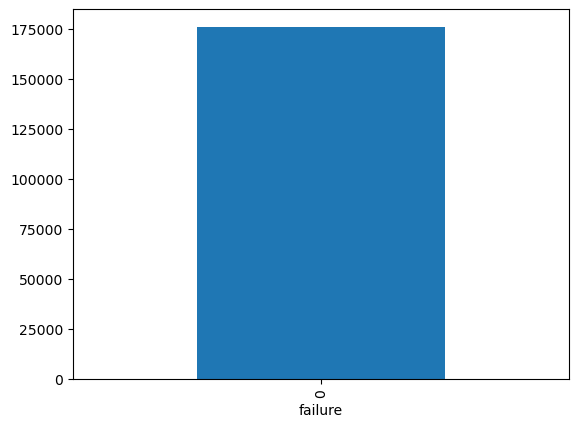

In [6]:
caxton['failure'].value_counts().plot(kind='bar', y='failure')

# Dataset Preperation

In [37]:
class ImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, index):
        img_path = self.data.iloc[index]['img_path']
        failure = self.data.iloc[index]['failure']

        try:
            # Check if file exists
            if not os.path.exists(img_path):
                # raise FileNotFoundError(f"Image file not found: {img_path}")
                img = torch.zeros((3, 224, 224), dtype=torch.uint8)  
                failure = 0
                return img, failure

            # Read image
            img = cv2.imread(img_path)
            
            # Check if image is None (indicating a read error)
            if img is None:
                raise IOError(f"Error reading image file: {img_path}")

            if self.transform:
                img = self.transform(img)

        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            # Return a placeholder image and the failure label
            img = np.zeros((224, 224, 3), dtype=np.uint8)  
            if self.transform:
                img = self.transform(img)

        return img, failure

    def __len__(self):
        return len(self.data)

In [38]:
# Set random seed for reproducibility
torch.manual_seed(42)

batch_size = 64

# CNN hyperparameters
input_channels = 3  # RGB images
num_classes = 1 # Binary classification (normal vs failure)
learning_rate = 1e-3
num_epochs = 50
dropout_rate = 0.5

# Define image dimensions
img_height = 224
img_width = 224

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [39]:
train_df, test_df = train_test_split(caxton, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42) 

# Create datasets
train_dataset = ImageDataset(train_df, transform)
val_dataset = ImageDataset(val_df, transform)
test_dataset = ImageDataset(test_df, transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [50]:
class model(nn.Module):
    def __init__(self, input_channels, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return torch.flatten(x)

In [51]:
model = model(input_channels, num_classes).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.BCEWithLogitsLoss()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch, (inputs, labels) in tqdm(enumerate(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward Pass
        outputs = model(inputs)
        loss = loss_fn(outputs, labels.float())
        
        # Backward Pass and Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        predicted = (outputs > 0).float()
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)
    
    train_loss /= len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels.float())
            val_loss += loss.item()
            predicted = (outputs > 0).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    
    val_loss /= len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    print()

Epoch 1/50: 0it [00:00, ?it/s]


TypeError: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.

In [ ]:
test_loss = 0
test_correct = 0
test_total = 0
with torch.no_grad():
    model.eval()
    for inputs, labels in tqdm(test_loader, desc="Test"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        loss = loss_fn(outputs, labels.float())

        test_loss += loss.item()
        predicted = (outputs > 0).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)
    
    test_loss /= len(test_loader)
    test_accuracy = 100 * test_correct / test_total